## 準備

### 何ができて何ができないのか？

In [1]:
import json

with open("rag_truth_test.json", "r") as f:
    test_data = json.load(f)

dev_data = test_data

In [2]:
# prefixをつける
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement as true or false (based on the references above): " + d["text"]
    return data


dev_data = add_prefix(dev_data)
dev_data[0]



{'ref': 'The FBI charged a Philadelphia woman on Thursday with trying to travel overseas to fight for ISIS. She\'s one of three women arrested this week on terror charges. Two New York women were also taken into custody. An FBI complaint cites numerous social media messages dating back to August 2013 that were sent by Keonna Thomas, 30, also known as "Young Lioness" and "Fatayat Al Khilafah." One Twitter message said, "If we truly knew the realities ... we all would be rushing to join our brothers in the front lines pray ALLAH accept us as shuhada [martyrs]." Another said, "When you\'re a mujahid [violent jihadi fighter] your death becomes a wedding." The FBI said Thomas purchased an electronic visa to Turkey on March 23. Turkey is known as the easiest place from which to enter Syria and join ISIS. An ISIS manual advises recruits to buy round-trip tickets to vacation spots such as Spain and then purchase tickets for their real destination once they arrive overseas, the FBI said. On Mar

In [3]:
# task_type: QA, Data2txt, Summary
task_name = "Summary"
dev_data = [d for d in dev_data if d["task_type"] == task_name]

In [4]:
from datasets import Dataset, DatasetDict
import pandas as pd


dev_df = pd.DataFrame(dev_data)
dev_ds = Dataset.from_pandas(dev_df)

raw_datasets = DatasetDict({"dev":dev_ds})
raw_datasets

DatasetDict({
    dev: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 900
    })
})

### no_rag

In [5]:
from transformers import AutoModel, AutoTokenizer
from models import NoRagModel

base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")
# モデルとトークナイザーを読み込む
name = "./1216_no_rag"
model = NoRagModel.from_pretrained(base_model,name)
tokenizer = AutoTokenizer.from_pretrained(name)


2025-01-23 13:24:49.871431: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 13:24:50.268171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 13:24:50.448942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 13:24:50.449335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 13:24:50.779741: I tensorflow/core/platform/cpu_feature_gua

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
import torch

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [8]:
from transformers import AutoTokenizer, DataCollatorWithPadding

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
# tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

In [9]:
tokenized_datasets

DatasetDict({
    dev: Dataset({
        features: ['ref', 'labels', 'source', 'model', 'task_type', 'source_id', 'input_ids', 'attention_mask'],
        num_rows: 900
    })
})

In [10]:
results = []
for i, d in enumerate(tokenized_datasets["dev"]):
    results.append({"id": i,"label":d["labels"],"task":d["task_type"]})

results[0]

{'id': 0, 'label': 0, 'task': 'Summary'}

In [11]:
# devセットで推論して、logitと結果をファイルに保存
import torch
from tqdm import tqdm
model.eval()


for i,d in tqdm(enumerate(tokenized_datasets["dev"])):
    input_ids =torch.tensor(d["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(d["attention_mask"]).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        predicted_index = torch.argmax(logits, dim=-1)
    results[i]["no_rag_logits"] = logits.cpu().numpy()
    results[i]["no_rag_label"] = predicted_index.cpu().numpy()
        
    


0it [00:00, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_bmm)

In [10]:
from sklearn.metrics import accuracy_score, f1_score

# サンプルデータ
data = results

# 正解ラベルと予測ラベルをリストに抽出
true_labels = [item['label'] for item in data]
predicted_labels = [item['no_rag_label'][0] for item in data]

# accuracy と F1-score の計算
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='binary')  # binary タスク用

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")


Accuracy: 0.7655555555555555
F1-score: 0.6520065970313359


### rag

In [11]:
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
import torch
from models import RagModel

base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")
# モデルとトークナイザーを読み込む
name = "./1216_rag"
model = RagModel.from_pretrained(base_model,name)
tokenizer = AutoTokenizer.from_pretrained(name)

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


def tokenize_function(examples):
    ref = tokenizer(examples["ref"],truncation=True, max_length=512)
    text = tokenizer(examples["text"],truncation=True, max_length=512)
    return {
        "ref_input_ids":ref["input_ids"],
        "ref_attention_mask":ref["attention_mask"],
        "text_input_ids":text["input_ids"],
        "text_attention_mask":text["attention_mask"],
    }

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text","ref"])
#tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [12]:
import torch
from tqdm import tqdm
model.eval()


for i,d in tqdm(enumerate(tokenized_datasets["dev"])):
    ref_input_ids = torch.tensor(d["ref_input_ids"]).unsqueeze(0).to(device)
    text_input_ids = torch.tensor(d["text_input_ids"]).unsqueeze(0).to(device)
    input_ids = [ref_input_ids, text_input_ids]
    ref_attention_mask = torch.tensor(d["ref_attention_mask"]).unsqueeze(0).to(device)
    text_attention_mask = torch.tensor(d["text_attention_mask"]).unsqueeze(0).to(device)
    attention_mask = [ref_attention_mask, text_attention_mask]
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs["logits"]
        predicted_index = torch.argmax(logits, dim=-1)
    results[i]["rag_logits"] = logits.cpu().numpy()
    results[i]["rag_label"] = predicted_index.cpu().numpy()
        

2700it [12:19,  3.65it/s]


In [13]:
from sklearn.metrics import accuracy_score, f1_score

# サンプルデータ
data = results

# 正解ラベルと予測ラベルをリストに抽出
true_labels = [item['label'] for item in data]
predicted_labels = [item['rag_label'][0] for item in data]

# accuracy と F1-score の計算
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='binary')  # binary タスク用

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Accuracy: 0.8096296296296296
F1-score: 0.7414486921529175


### triplet

In [46]:
# データ数を他2つと合わせる
def create_trip(data, id_list):
    trip = []
    for id in id_list:
        num = 0
        no_hal = []
        has_hal = []
        for d in data:
            if num == 6:
                num = 0
                if no_hal == [] or has_hal == []:
                    break
                '''
                for no in no_hal:
                    for has in has_hal:
                        trip.append({"anchor":ref,"positive": no, "negative": has, "labels":[0,1]})
                '''
                if len(no_hal)==1 or len(no_hal)==5:
                    trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                elif len(no_hal)==2 or len(no_hal)==4:
                    trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                    trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
                elif len(no_hal)==3:
                    trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                    trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
                    trip.append({"anchor":ref,"positive": no_hal[2], "negative": has_hal[2], "labels":[0,1]})
                no_hal = []
                has_hal = []
                break
            elif d["source_id"] == id:
                num +=1
                ref = d["ref"]
                if d["labels"] == 0:
                    no_hal.append(d["text"])
                else:
                    has_hal.append(d["text"])
        if num == 6:
            if len(no_hal)==1 or len(no_hal)==5:
                trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
            elif len(no_hal)==2 or len(no_hal)==4:
                trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
            elif len(no_hal)==3:
                trip.append({"anchor":ref,"positive": no_hal[0], "negative": has_hal[0], "labels":[0,1]})
                trip.append({"anchor":ref,"positive": no_hal[1], "negative": has_hal[1], "labels":[0,1]})
                trip.append({"anchor":ref,"positive": no_hal[2], "negative": has_hal[2], "labels":[0,1]})
    return trip

def create_trip_ver2(data, id_list):
    trip = []
    for d in data:
        if d["labels"] == 0: # halluってない
            trip.append({"anchor":d["ref"],"positive": d["text"], "negative": "hallucination", "labels":[0,0]})
        else:
            trip.append({"anchor":d["ref"],"positive": "not hallucination", "negative": d["text"], "labels":[1,1]})
    return trip
        

In [47]:
from datasets import Dataset, DatasetDict
import pandas as pd

dev_id = [d["source_id"] for d in dev_data]
dev_id = list(set(dev_id))
dev_trip = create_trip_ver2(dev_data, dev_id)


dev_df = pd.DataFrame(dev_trip)
dev_ds = Dataset.from_pandas(dev_df)

raw_datasets = DatasetDict({"dev":dev_ds})
raw_datasets

DatasetDict({
    dev: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 2700
    })
})

In [48]:
import torch.nn.functional as F
import torch
import torch.nn as nn

def triplet_loss(anchor_output, positive_output, negative_output, positive_logits, negative_logits):
    # ラベル予測の損失計算
    positive_targets = torch.zeros(positive_output.size(0), dtype=torch.long).to(device)  # ラベル1 (positive)
    negative_targets = torch.ones(negative_output.size(0), dtype=torch.long).to(device)
    positive_loss = nn.CrossEntropyLoss()(positive_logits, positive_targets)
    negative_loss = nn.CrossEntropyLoss()(negative_logits, negative_targets)

    # ラベル予測の損失を平均
    classification_loss = (positive_loss + negative_loss) / 2.0

    # トリプレット損失の計算
    #triplet_loss = nn.TripletMarginLoss(margin=1, p=2)(anchor_output, positive_output, negative_output)
    triplet_loss_fn = (nn.TripletMarginWithDistanceLoss(margin=1.0,distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
    triplet_loss = triplet_loss_fn(anchor_output, positive_output, negative_output)
    # 最終損失
    total_loss = classification_loss + triplet_loss 

    return classification_loss, triplet_loss

In [49]:
from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
import torch
from models import TripletModel


base_model = AutoModel.from_pretrained("microsoft/Phi-3.5-mini-instruct")
# モデルとトークナイザーを読み込む
name = "./1228_triplet"
model = TripletModel.from_pretrained(base_model, triplet_loss, name)
tokenizer = AutoTokenizer.from_pretrained(name)

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


def tokenize_function(examples):
    anchor = tokenizer(examples["anchor"], truncation=True,max_length=512)
    positive = tokenizer(examples["positive"], truncation=True,max_length=512)
    negative = tokenizer(examples["negative"], truncation=True,max_length=512)

    return {
        "anchor_input_ids": anchor["input_ids"],
        "anchor_attention_mask": anchor["attention_mask"],
        "positive_input_ids": positive["input_ids"],
        "positive_attention_mask": positive["attention_mask"],
        "negative_input_ids": negative["input_ids"],
        "negative_attention_mask": negative["attention_mask"],
    }


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["anchor", "positive", "negative"])
#tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [50]:
import torch
from tqdm import tqdm
model.eval()


for i,d in tqdm(enumerate(tokenized_datasets["dev"])):
    
    flag = False # hallってるのはTrue
    if d["labels"][0] ==1:
        flag = True
    
    anchor_input_ids = torch.tensor(d["anchor_input_ids"], dtype=torch.long).unsqueeze(0).to(device)
    positive_input_ids = torch.tensor(d["positive_input_ids"], dtype=torch.long).unsqueeze(0).to(device)
    negative_input_ids = torch.tensor(d["negative_input_ids"], dtype=torch.long).unsqueeze(0).to(device)
    input_ids = [anchor_input_ids, positive_input_ids, negative_input_ids]
    anchor_attention_mask = torch.tensor(d["anchor_attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
    positive_attention_mask = torch.tensor(d["positive_attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
    negative_attention_mask = torch.tensor(d["negative_attention_mask"], dtype=torch.long).unsqueeze(0).to(device)
    attention_mask = [anchor_attention_mask, positive_attention_mask, negative_attention_mask]
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        #print(d["labels"])
        if flag:
            logits = outputs.logits[1]
        else:
            logits = outputs.logits[0]
        predicted_index = torch.argmax(logits, dim=-1)
    results[i]["triplet_logits"] = logits.cpu().numpy()
    results[i]["triplet_label"] = predicted_index.cpu().numpy()
    
    
        

2700it [15:29,  2.90it/s]


In [51]:
from sklearn.metrics import accuracy_score, f1_score

# サンプルデータ
data = results

# 正解ラベルと予測ラベルをリストに抽出
true_labels = [item['label'] for item in data]
predicted_labels = [item['triplet_label'][0] for item in data]

# accuracy と F1-score の計算
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='binary')  # binary タスク用

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Accuracy: 0.7077777777777777
F1-score: 0.6265972550875533


### 検証

In [38]:
results[-1]

{'id': 2699,
 'label': 0,
 'task': 'QA',
 'no_rag_logits': [[5.56593656539917, -5.5176544189453125]],
 'no_rag_label': [0],
 'rag_logits': [[2.7037570476531982, -1.0352840423583984]],
 'rag_label': [0],
 'triplet_logits': [[1.4126927852630615, -0.585303544998169]],
 'triplet_label': [0]}

In [23]:
# まず保存
import numpy as np
import json
for result in results:
    if isinstance(result["no_rag_logits"], np.ndarray):
        result["no_rag_logits"] = result["no_rag_logits"].tolist()
    if isinstance(result["rag_logits"], np.ndarray):
        result["rag_logits"] = result["rag_logits"].tolist()
    if isinstance(result["triplet_logits"], np.ndarray):
        result["triplet_logits"] = result["triplet_logits"].tolist()
    if isinstance(result["no_rag_label"], np.ndarray):
        result["no_rag_label"] = result["no_rag_label"].tolist()
    if isinstance(result["rag_label"], np.ndarray):
        result["rag_label"] = result["rag_label"].tolist()
    if isinstance(result["triplet_label"], np.ndarray):
        result["triplet_label"] = result["triplet_label"].tolist()



with open("check_improve.json", "w") as f:
    json.dump(results, f)

## ここからでok

In [5]:
import json

with open('check_improve.json',"r") as f:
    data = json.load(f)
    
results = data
    

In [6]:
# no_rag→tripletでhallを検出できるようになった例
num=0
id_000 = [] # どっちでもhalじゃないと言えた
id_001 = [] # どっちでも検出できなかった
id_010 = [] # tripletの時に過検出
id_011 = [] # tripletで検出できるようになった
id_100 = [] # tripletでnoと言えるようになった
id_101 = [] # tripletで検出できなくなった
id_110 = [] # どっちでも過検出
id_111 = [] # どっちでも検出できた
for result in results:
    if result["no_rag_label"][0]==0 and result["triplet_label"][0]==0 and result["label"]==0:
        id_000.append(result["id"])
    elif result["no_rag_label"][0]==0 and result["triplet_label"][0]==0 and result["label"]==1:
        id_001.append(result["id"])
    elif result["no_rag_label"][0]==0 and result["triplet_label"][0]==1 and result["label"]==0:
        id_010.append(result["id"])
    elif result["no_rag_label"][0]==0 and result["triplet_label"][0]==1 and result["label"]==1:
        id_011.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==0 and result["label"]==0:
        id_100.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==0 and result["label"]==1:
        id_101.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==1 and result["label"]==0:
        id_110.append(result["id"])
    elif result["no_rag_label"][0]==1 and result["triplet_label"][0]==1 and result["label"]==1:
        id_111.append(result["id"])
    
    
# 000:972, 001:181, 010:502, 011:169, 100:71, 101:80, 110:212, 111:513
print(len(id_000),len(id_001),len(id_010),len(id_011),len(id_100),len(id_101),len(id_110),len(id_111))

972 181 502 169 71 80 212 513


### 長さ

In [23]:
from collections import defaultdict
import numpy as np

hal_model_len_qa = defaultdict(lambda:[])
hal_model_len_d2t = defaultdict(lambda:[])
hal_model_len_sum = defaultdict(lambda:[])

for d in test_data_span:
    if d["hallucination_id"] == []:
        continue
        
    if d["task_type"] == "QA":
        hal_model_len_qa[d["model"]].append(len(d["text"]))
    elif d["task_type"] == "Data2txt":
        hal_model_len_d2t[d["model"]].append(len(d["text"]))
    else:
        hal_model_len_sum[d["model"]].append(len(d["text"]))
        
hal_model_len_qa = dict(hal_model_len_qa)
hal_model_len_d2t = dict(hal_model_len_d2t)
hal_model_len_sum = dict(hal_model_len_sum)

hal_model_len_qa = {k: round(np.mean(v), 1) for k, v in hal_model_len_qa.items()}
hal_model_len_d2t = {k: round(np.mean(v), 1) for k, v in hal_model_len_d2t.items()}
hal_model_len_sum = {k: round(np.mean(v), 1) for k, v in hal_model_len_sum.items()}


print(hal_model_len_qa)
print(hal_model_len_d2t)
print(hal_model_len_sum)

{'llama-2-13b-chat': 925.9, 'mistral-7B-instruct': 738.5, 'llama-2-7b-chat': 1027.0, 'llama-2-70b-chat': 796.7, 'gpt-3.5-turbo-0613': 613.8, 'gpt-4-0613': 294.0}
{'gpt-4-0613': 810.2, 'mistral-7B-instruct': 879.8, 'llama-2-7b-chat': 885.4, 'llama-2-13b-chat': 1128.9, 'llama-2-70b-chat': 986.3, 'gpt-3.5-turbo-0613': 1331.9}
{'llama-2-13b-chat': 613.4, 'llama-2-70b-chat': 719.3, 'mistral-7B-instruct': 683.8, 'gpt-3.5-turbo-0613': 1209.5, 'llama-2-7b-chat': 646.0, 'gpt-4-0613': 861.0}


In [26]:
from collections import defaultdict
import numpy as np

hal_model_len_qa_imp = defaultdict(lambda:[])
hal_model_len_d2t_imp = defaultdict(lambda:[])
hal_model_len_sum_imp = defaultdict(lambda:[])

for i in id_001 + id_101:
    d = test_data_span[i]
    if d["hallucination_id"] == []:
        continue
        
    if d["task_type"] == "QA":
        hal_model_len_qa_imp[d["model"]].append(len(d["text"]))
    elif d["task_type"] == "Data2txt":
        hal_model_len_d2t_imp[d["model"]].append(len(d["text"]))
    else:
        hal_model_len_sum_imp[d["model"]].append(len(d["text"]))
        
hal_model_len_qa_imp = dict(hal_model_len_qa_imp)
hal_model_len_d2t_imp = dict(hal_model_len_d2t_imp)
hal_model_len_sum_imp = dict(hal_model_len_sum_imp)

hal_model_len_qa_imp = {k: round(np.mean(v), 1) for k, v in hal_model_len_qa_imp.items()}
hal_model_len_d2t_imp = {k: round(np.mean(v), 1) for k, v in hal_model_len_d2t_imp.items()}
hal_model_len_sum_imp = {k: round(np.mean(v), 1) for k, v in hal_model_len_sum_imp.items()}


print(hal_model_len_qa_imp)
print(hal_model_len_d2t_imp)
print(hal_model_len_sum_imp)

{'llama-2-70b-chat': 486.0, 'mistral-7B-instruct': 739.9, 'gpt-3.5-turbo-0613': 229.0, 'llama-2-7b-chat': 450.0, 'gpt-4-0613': 294.0, 'llama-2-13b-chat': 672.0}
{'gpt-4-0613': 811.2, 'gpt-3.5-turbo-0613': 1331.9, 'llama-2-7b-chat': 722.8, 'llama-2-70b-chat': 794.2, 'mistral-7B-instruct': 927.7, 'llama-2-13b-chat': 1057.3}
{'llama-2-70b-chat': 654.2, 'llama-2-13b-chat': 514.8, 'gpt-3.5-turbo-0613': 1209.5, 'llama-2-7b-chat': 672.8, 'gpt-4-0613': 861.0, 'mistral-7B-instruct': 646.5}


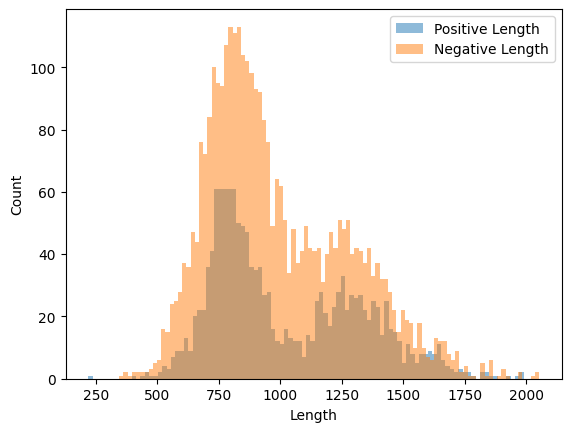

In [51]:
# 長さの分布
import matplotlib.pyplot as plt


d2t_posi_len=[]
d2t_nega_len =[]

for d in train_data_span:
    if d["task_type"] != "Data2txt":
        continue
    
    if d["labels"] == 1:
        d2t_nega_len.append(len(d["text"]))
    else:
        d2t_posi_len.append(len(d["text"]))
        
plt.hist(d2t_posi_len, alpha=0.5, label="Positive Length", bins=100)
plt.hist(d2t_nega_len, alpha=0.5, label="Negative Length", bins=100)
plt.xlabel("Length")
plt.ylabel("Count")
plt.legend()
plt.show()

In [36]:
len(d2t_nega_len), len(d2t_posi_len)

(0, 1)

### type

In [5]:
# hallucinationのタイプで見てみる？

import json

with open("rag_truth_span_test.json", "r") as f:
    test_data_span = json.load(f)
with open("rag_truth_span_train.json", "r") as f:
    train_data_span = json.load(f)
with open("rag_truth_span_dev.json", "r") as f:
    dev_data_span = json.load(f)


In [7]:
a = []
for d in dev_data_span:
    if d["hallucination_id"] == []:
        continue
    hal_type = []
    for hal_id in d["hallucination_id"]:
        hal_type.append(hal_id["label_type"])
        
    if d["task_type"] == "QA":
        for hal in hal_type:
            if hal == "Subtle Conflict":
                #print(d)
                a.append(d)
    

In [11]:
a[3]

{'ref': "{'question': 'how do you remove programs and processes from windows xp', 'passages': 'passage 1:When the programs and features window opens select the program your want to uninstall from the list and click on the Uninstall button. 5. Confirm that you want to uninstall a program by clicking on the Yes button.\\n\\npassage 2:In the list of programs, click Windows XP, and then click Change/Remove. 3. Click Uninstall Windows XP, and then click Continue. 4. If any programs have been modified since the upgrade to Windows XP, you will receive a warning message.\\n\\npassage 3:When the Start Menu opens select Control Panel. 3. Depending on your view options either click on uninstall a program or program and features. 4. When the programs and features window opens select the program your want to uninstall from the list and click on the Uninstall button.\\n\\n'}",
 'text': 'Based on the provided passages, here is how you can remove programs and processes from Windows XP:\n\nPassage 1: T

In [4]:
test_data_span[0]

{'ref': 'The FBI charged a Philadelphia woman on Thursday with trying to travel overseas to fight for ISIS. She\'s one of three women arrested this week on terror charges. Two New York women were also taken into custody. An FBI complaint cites numerous social media messages dating back to August 2013 that were sent by Keonna Thomas, 30, also known as "Young Lioness" and "Fatayat Al Khilafah." One Twitter message said, "If we truly knew the realities ... we all would be rushing to join our brothers in the front lines pray ALLAH accept us as shuhada [martyrs]." Another said, "When you\'re a mujahid [violent jihadi fighter] your death becomes a wedding." The FBI said Thomas purchased an electronic visa to Turkey on March 23. Turkey is known as the easiest place from which to enter Syria and join ISIS. An ISIS manual advises recruits to buy round-trip tickets to vacation spots such as Spain and then purchase tickets for their real destination once they arrive overseas, the FBI said. On Mar

In [5]:
from collections import defaultdict

hal_type_qa = defaultdict(lambda:0)
hal_type_d2t = defaultdict(lambda:0)
hal_type_sum = defaultdict(lambda:0)

for d in test_data_span:
    if d["hallucination_id"] == []:
        continue
    hal_type = []
    for hal_id in d["hallucination_id"]:
        hal_type.append(hal_id["label_type"])
        
    if d["task_type"] == "QA":
        for hal in hal_type:
            hal_type_qa[hal] += 1
    elif d["task_type"] == "Data2txt":
        for hal in hal_type:
            hal_type_d2t[hal] += 1
    else:
        for hal in hal_type:
            hal_type_sum[hal] += 1
print(dict(hal_type_qa))
print(dict(hal_type_d2t))
print(dict(hal_type_sum))

{'Evident Baseless Info': 156, 'Evident Conflict': 30, 'Subtle Baseless Info': 49}
{'Evident Conflict': 489, 'Evident Baseless Info': 465, 'Subtle Baseless Info': 95, 'Subtle Conflict': 5}
{'Evident Conflict': 100, 'Evident Baseless Info': 117, 'Subtle Conflict': 11, 'Subtle Baseless Info': 16}


In [6]:
from collections import defaultdict

hal_type_qa_imp = defaultdict(lambda:0)
hal_type_d2t_imp = defaultdict(lambda:0)
hal_type_sum_imp = defaultdict(lambda:0)

for i in id_001 + id_011:
    if test_data_span[i]["hallucination_id"]==[]:
        continue
    hal_type_imp = []
    for hal_id in test_data_span[i]["hallucination_id"]:
        hal_type_imp.append(hal_id["label_type"])
        
    if test_data_span[i]["task_type"] == "QA":
        for hal in hal_type_imp:
            hal_type_qa_imp[hal] += 1
    elif test_data_span[i]["task_type"] == "Data2txt":
        for hal in hal_type_imp:
            hal_type_d2t_imp[hal] += 1
    else:
        for hal in hal_type_imp:
            hal_type_sum_imp[hal] += 1
print(dict(hal_type_qa_imp))
print(dict(hal_type_d2t_imp))
print(dict(hal_type_sum_imp))

{'Evident Conflict': 23, 'Evident Baseless Info': 63, 'Subtle Baseless Info': 18}
{'Evident Conflict': 61, 'Evident Baseless Info': 73, 'Subtle Baseless Info': 19, 'Subtle Conflict': 2}
{'Evident Conflict': 82, 'Subtle Conflict': 9, 'Evident Baseless Info': 86, 'Subtle Baseless Info': 6}


In [7]:
sample = []
for i in id_011:
    if test_data_span[i]["task_type"]!="QA":
        continue
    
    hal_type2 = []
    for hal_id in test_data_span[i]["hallucination_id"]:
        hal_type2.append(hal_id["label_type"])
    
    if "Evident Conflict" in hal_type2:
        sample.append(test_data_span[i])

In [8]:
sample[-2]

{'ref': '{\'question\': \'history of the word gemini\', \'passages\': "passage 1:The word “Gemini” is a Latin word for twins and it is one of the constellations that actually look like its name would suggest. The first known reference of the Gemini constellation was in Aristotle’s Meteorologica, over 300 years BC. He mentions that he observed an occulting a star in Gemini and speaks of observing Jupiter in conjunction with it.\\n\\npassage 2:Gemini History. The History of Gemini. As other signs in the zodiac, Gemini is not in the same position as the constellation of Gemini. In the zodiac, it follows Taurus and takes the third 30 degrees of the zodiacal circle. Gemini is a mutable sign that is preceding the summer, and as such, it announces change while ruling the time of year when Taurus spring has ended, and life on Earth is about to change.\\n\\npassage 3:Gemini Mythology The Story Behind the Gemini Zodiac Sign. The origins of some constellation myths are heavily debated. Gemini myt

In [9]:
sample2 = []
for i in id_101:
    if test_data_span[i]["task_type"]!="Data2txt":
        continue
    
    hal_type2 = []
    for hal_id in test_data_span[i]["hallucination_id"]:
        hal_type2.append(hal_id["label_type"])
    
    if "Subtle Baseless Info" in hal_type2 and "Evident Baseless Info" in hal_type2:
        sample2.append(test_data_span[i])

In [10]:
sample2[0]

{'ref': '{\'name\': \'Finch & Fork\', \'address\': \'31 W Carrillo St\', \'city\': \'Santa Barbara\', \'state\': \'CA\', \'categories\': \'Breakfast & Brunch, American (New), Restaurants, American (Traditional), Nightlife, Bars\', \'hours\': {\'Monday\': \'17:30-23:0\', \'Tuesday\': \'17:0-21:0\', \'Wednesday\': \'17:0-21:0\', \'Thursday\': \'17:0-21:0\', \'Friday\': \'17:0-21:0\', \'Saturday\': \'17:0-21:0\', \'Sunday\': \'9:0-14:0\'}, \'attributes\': {\'BusinessParking\': {\'garage\': True, \'street\': True, \'validated\': True, \'lot\': False, \'valet\': True}, \'RestaurantsReservations\': True, \'OutdoorSeating\': False, \'WiFi\': \'free\', \'RestaurantsTakeOut\': True, \'RestaurantsGoodForGroups\': True, \'Music\': False, \'Ambience\': {\'romantic\': False, \'intimate\': False, \'classy\': True, \'hipster\': False, \'divey\': False, \'touristy\': False, \'trendy\': False, \'upscale\': False, \'casual\': False}}, \'business_stars\': 4.0, \'review_info\': [{\'review_stars\': 5.0, \'

In [11]:
sample3 = []
for i in id_011:
    if test_data_span[i]["task_type"]!="Summary":
        continue
    
    hal_type2 = []
    for hal_id in test_data_span[i]["hallucination_id"]:
        hal_type2.append(hal_id["label_type"])
    
    if "Subtle Baseless Info" in hal_type2 or "Evident Baseless Info" in hal_type2:
        sample3.append(test_data_span[i])

In [13]:
sample3[6]

{'ref': 'A nuclear submarine being repaired at a Russian shipyard has caught on fire, according to a law enforcement source speaking to Russia\'s state-run news agency ITAR-Tass. "The submarine is in a dry dock," Tass reports, citing the source, and there is no ammunition on board. "The rubber insulation between the submarine\'s light and pressure hull is on fire," Tass reported. Russia\'s RIA Novosti news agency says insulation caught on fire as welding work was being done on the submarine. Tass reported that the fire began on a sub in the Zvyozdochka shipyard in northwestern Russia. Zvyozdochka spokesman Yevgeny Gladyshev told the news agency that the sub had been undergoing repairs since November 2013. "Nuclear fuel from the sub\'s reactor has been unloaded," he reportedly said. "There are no armaments or chemically active, dangerous substances, fissionable materials on it," Gladyshev said to Tass. "The enterprise\'s personnel left the premises when the submarine caught fire, no one

In [17]:
sample3_len = [len(x["ref"])+len(x["text"]) for x in sample3]

# 6 17

### embedding

In [14]:
!pip install --upgrade transformers datasets huggingface_hub


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     |████████████████████████████████| 480 kB 9.6 MB/s eta 0:00:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.19.1
    Uninstalling datasets-2.19.1:
      Successfully uninstalled datasets-2.19.1
You should consider upgrading via the '/home/3/uw03923/nlp/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import json

with open("rag_truth_test.json", "r") as f:
    test_data = json.load(f)
    
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement as true or false based on the references above: " + d["text"]
    return data

test_data = add_prefix(test_data)

In [1]:
import json

with open("rag_truth_dev.json", "r") as f:
    test_data = json.load(f)
    
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement as true or false based on the references above: " + d["text"]
    return data

test_data = add_prefix(test_data)

In [4]:
# task_type: QA, Data2txt, Summary
task_name = "QA"

test_data = [d for d in test_data if d["task_type"] == task_name]

In [3]:
import random

test_data = random.sample(test_data, 100)
len(test_data)

100

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import accelerate
import bitsandbytes
import transformers
from models_rob import NoRagModel

# ===== 1. RoBERTaで埋め込みを生成 =====
# トークナイザーとモデルを読み込む
model_name = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name,device_map="auto")


#model = NoRagModel.from_pretrained(base_model, "0102_no_rag_rob")


# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# サンプルデータ
texts = [x["text"] for x in test_data]
#texts = ["これはテストです。", "これはテストですか。", "これはテストです。"]

# トークン化
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# RoBERTaで埋め込みを取得（[CLS]トークンの出力を使用）
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs[0][:,-1,:] #baseの時
    #embeddings =outputs.output #訓練済みの時
    embeddings = embeddings.cpu().numpy()  # numpy形式に変換

# ===== 2. UMAPで次元削減 =====
# 次元削減
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_reducer.fit_transform(embeddings)

#print(f"Number of texts: {len(texts)}")
#print(f"Shape of embeddings_2d: {embeddings_2d.shape}")
#print("Shape of embeddings:", embeddings.shape)


# ===== 3. 可視化 =====
# プロット
plt.figure(figsize=(8, 8))
for i, text in enumerate(texts):
    """
    if test_data[i]["task_type"] == "QA":
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "red")
    elif test_data[i]["task_type"] == "Data2txt":
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "blue")
    else:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "green")
    """
    if test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "red",s = 10,marker="^")
    elif test_data[i]["task_type"] == "QA" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#ff1493",s = 10)
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#00008b",s = 10,marker="^")
    elif test_data[i]["task_type"] == "Data2txt" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "blue",s = 10)
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 1:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "green",s = 10,marker="^")
    elif test_data[i]["task_type"] == "Summary" and test_data[i]["labels"] == 0:
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1],color = "#32cd32",s = 10)

"""
plt.scatter([], [],color = "red", label = "QA")
plt.scatter([], [],color = "blue", label = "Data2txt")
plt.scatter([], [],color = "green", label = "Summary")
"""
plt.scatter([], [],color = "red", label = "QA (hal)",marker="^")
plt.scatter([], [],color = "#ff1493", label = "QA (not hal)")
#plt.scatter([], [],color = "#00008b", label = "Data2txt (hal)",marker="^")
#plt.scatter([], [],color = "blue", label = "Data2txt (not hal)")
#plt.scatter([], [],color = "green", label = "Summary (hal)",marker="^")
#plt.scatter([], [],color = "#32cd32", label = "Summary (not hal)")

plt.title("UMAP Visualization of RoBERTa Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

plt.legend()
plt.show()


2025-01-17 15:53:07.995293: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 15:53:08.008292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 15:53:08.025242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 15:53:08.025273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 15:53:08.037857: I tensorflow/core/platform/cpu_feature_gua

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_bmm)

### モデル

In [1]:
import json

with open("rag_truth_span_test_sim.json", "r") as f:
    test_data_span = json.load(f)
with open("rag_truth_span_train.json", "r") as f:
    train_data_span = json.load(f)
with open("rag_truth_span_dev.json", "r") as f:
    dev_data_span = json.load(f)

In [2]:
test_data_span[0]

{'ref': 'The FBI charged a Philadelphia woman on Thursday with trying to travel overseas to fight for ISIS. She\'s one of three women arrested this week on terror charges. Two New York women were also taken into custody. An FBI complaint cites numerous social media messages dating back to August 2013 that were sent by Keonna Thomas, 30, also known as "Young Lioness" and "Fatayat Al Khilafah." One Twitter message said, "If we truly knew the realities ... we all would be rushing to join our brothers in the front lines pray ALLAH accept us as shuhada [martyrs]." Another said, "When you\'re a mujahid [violent jihadi fighter] your death becomes a wedding." The FBI said Thomas purchased an electronic visa to Turkey on March 23. Turkey is known as the easiest place from which to enter Syria and join ISIS. An ISIS manual advises recruits to buy round-trip tickets to vacation spots such as Spain and then purchase tickets for their real destination once they arrive overseas, the FBI said. On Mar

In [9]:
from collections import defaultdict

hal_model_qa = defaultdict(lambda:0)
hal_model_d2t = defaultdict(lambda:0)
hal_model_sum = defaultdict(lambda:0)

for d in test_data_span:
    if d["hallucination_id"] == []:
        continue
        
    if d["task_type"] == "QA":
        hal_model_qa[d["model"]] += 1
    elif d["task_type"] == "Data2txt":
        hal_model_d2t[d["model"]] += 1
    else:
        hal_model_sum[d["model"]] += 1
print(dict(hal_model_qa))
print(dict(hal_model_d2t))
print(dict(hal_model_sum))

{'llama-2-13b-chat': 36, 'mistral-7B-instruct': 31, 'llama-2-7b-chat': 52, 'llama-2-70b-chat': 35, 'gpt-3.5-turbo-0613': 5, 'gpt-4-0613': 1}
{'gpt-4-0613': 35, 'mistral-7B-instruct': 134, 'llama-2-7b-chat': 123, 'llama-2-13b-chat': 138, 'llama-2-70b-chat': 112, 'gpt-3.5-turbo-0613': 37}
{'llama-2-13b-chat': 33, 'llama-2-70b-chat': 24, 'mistral-7B-instruct': 86, 'gpt-3.5-turbo-0613': 4, 'llama-2-7b-chat': 51, 'gpt-4-0613': 6}


In [10]:
from collections import defaultdict

hal_model_qa_imp = defaultdict(lambda:0)
hal_model_d2t_imp = defaultdict(lambda:0)
hal_model_sum_imp = defaultdict(lambda:0)

for i in id_011 + id_111:
    d = test_data_span[i]
    if d["hallucination_id"] == []:
        continue
        
    if d["task_type"] == "QA":
        hal_model_qa_imp[d["model"]] += 1
    elif d["task_type"] == "Data2txt":
        hal_model_d2t_imp[d["model"]] += 1
    else:
        hal_model_sum_imp[d["model"]] += 1
print(dict(hal_model_qa_imp))
print(dict(hal_model_d2t_imp))
print(dict(hal_model_sum_imp))

{'llama-2-13b-chat': 35, 'llama-2-7b-chat': 51, 'llama-2-70b-chat': 29, 'mistral-7B-instruct': 24, 'gpt-3.5-turbo-0613': 4}
{'llama-2-70b-chat': 80, 'llama-2-13b-chat': 132, 'mistral-7B-instruct': 121, 'llama-2-7b-chat': 101, 'gpt-4-0613': 1}
{'llama-2-13b-chat': 20, 'mistral-7B-instruct': 39, 'llama-2-7b-chat': 34, 'llama-2-70b-chat': 11}


### 類似度

In [ ]:
%pip install transformers==4.44.0
%pip show transformers

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
from models_rob import NoRagModel, RagModel, TripletModel

#tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

name = "./0102_no_rag_rob"
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/RoBERTa-base")
base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
model = NoRagModel.from_pretrained(base_model,name)

def calc_sim(ref, text):
    # テキストをトークン化
    ref_tokens = tokenizer(ref, padding="longest", truncation=True, return_tensors="pt")
    text_tokens = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")
    
    # モデルの出力を取得（最終隠れ層）
    with torch.no_grad():  # 推論時には勾配計算を行わない
        ref_output = model(**ref_tokens)
        text_output = model(**text_tokens)
    #print(ref_output)
    # 全トークンを平均化して文のベクトル表現を得る
    #ref_embedding = ref_output.last_hidden_state.mean(dim=1).detach().numpy()
    #text_embedding = text_output.last_hidden_state.mean(dim=1).detach().numpy()
    ref_embedding = ref_output.output.cpu().numpy()
    text_embedding = text_output.output.cpu().numpy()
    #print(ref_embedding)

    # コサイン類似度を計算
    return cosine_similarity(ref_embedding, text_embedding)[0][0]

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/RoBERTa-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
from models_rob import NoRagModel, RagModel, TripletModel

#tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

name = "./0102_rag_rob"
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/RoBERTa-base")
base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
model = RagModel.from_pretrained(base_model,name)

def calc_sim(ref, text):
    # テキストをトークン化
    ref_tok = tokenizer(ref, padding="longest", truncation=True, return_tensors="pt")
    text_tok = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")
    
    inputs = {
    "input_ids":[ref_tok["input_ids"],text_tok["input_ids"]],
    "attention_mask":[ref_tok["attention_mask"],text_tok["attention_mask"]]
    }   
    
    # モデルの出力を取得（最終隠れ層）
    with torch.no_grad():  # 推論時には勾配計算を行わない
        output = model(**inputs)
    #print(ref_output)
    ref_output = output.output[0].cpu().numpy()
    text_output = output.output[1].cpu().numpy()
    #print(ref_embedding)

    # コサイン類似度を計算
    return cosine_similarity(ref_output, text_output)[0][0]

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/RoBERTa-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import torch.nn.functional as F
import torch
import torch.nn as nn

def triplet_loss(anchor_output, positive_output, negative_output, positive_logits, negative_logits):
    # ラベル予測の損失計算
    positive_targets = torch.zeros(positive_output.size(0), dtype=torch.long) # ラベル1 (positive)
    negative_targets = torch.ones(negative_output.size(0), dtype=torch.long)
    positive_loss = nn.CrossEntropyLoss()(positive_logits, positive_targets)
    negative_loss = nn.CrossEntropyLoss()(negative_logits, negative_targets)

    # ラベル予測の損失を平均
    classification_loss = (positive_loss + negative_loss) / 2.0

    # トリプレット損失の計算
    #triplet_loss = nn.TripletMarginLoss(margin=1, p=2)(anchor_output, positive_output, negative_output)
    triplet_loss_fn = (nn.TripletMarginWithDistanceLoss(margin=1.0,distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
    triplet_loss = triplet_loss_fn(anchor_output, positive_output, negative_output)
    # 最終損失
    total_loss = classification_loss + triplet_loss 

    return classification_loss, triplet_loss

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
from models_rob import NoRagModel, RagModel, TripletModel

#tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

name = "./0102_triplet_rob"
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/RoBERTa-base")
base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
model = TripletModel.from_pretrained(base_model,triplet_loss, name)

def calc_sim(ref, text,label):
    # テキストをトークン化
    ref_tok = tokenizer(ref, padding="longest", truncation=True, return_tensors="pt")
    text_tok = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")
    sample_tok = tokenizer("sample", padding="longest", truncation=True, return_tensors="pt")
    
    if label[0] == 1:
        inputs = {
        "input_ids":[ref_tok["input_ids"],sample_tok["input_ids"],text_tok["input_ids"]],
        "attention_mask":[ref_tok["attention_mask"],sample_tok["attention_mask"],text_tok["attention_mask"]],
        "labels": label
        }   
    elif label[0] == 0:
        inputs = {
        "input_ids":[ref_tok["input_ids"],text_tok["input_ids"], sample_tok["input_ids"]],
        "attention_mask":[ref_tok["attention_mask"],text_tok["attention_mask"], sample_tok["attention_mask"]],
        "labels": label
        }
    
    # モデルの出力を取得（最終隠れ層）
    with torch.no_grad():  # 推論時には勾配計算を行わない
        output = model(**inputs)
    #print(ref_output)
    ref_output = output.output[0].cpu().numpy()
    text_output = output.output[1].cpu().numpy()
    #print(ref_embedding)

    # コサイン類似度を計算
    return cosine_similarity(ref_output, text_output)[0][0]

/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/RoBERTa-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
calc_sim(test_data_span[0]["ref"], test_data_span[0]["text"], [test_data_span[0]["labels"]])

0.8732698

In [27]:
from tqdm import tqdm
qa_cos = []
d2t_cos = []
sum_cos = []

for d in tqdm(test_data_span):
    #if d["labels"] ==0:
    #    continue
    sim = calc_sim(d["ref"], d["text"], [d["labels"]])
    if d["task_type"] == "QA":
        qa_cos.append(sim)
        #d["sim_before"] = sim
        #d["sim_no_doc"] = sim
        #d["sim_doc"] = sim
        d["triplet"] = sim
    elif d["task_type"] == "Data2txt":
        d2t_cos.append(sim)
        #d["sim_before"] = sim
        #d["sim_no_doc"] = sim
        #d["sim_doc"] = sim
        d["triplet"] = sim
    else:
        sum_cos.append(sim)
        #d["sim_before"] = sim
        #d["sim_no_doc"] = sim
        #d["sim_doc"] = sim
        d["triplet"] = sim

print("QA", np.mean(qa_cos))
print("Data2txt", np.mean(d2t_cos))
print("Sum", np.mean(sum_cos))

100%|██████████| 2700/2700 [14:59<00:00,  3.00it/s] 

QA -0.026896995
Data2txt -0.08624694
Sum 0.55979466


In [29]:
test_data_span[10]

{'ref': 'Blue Bell ice cream has temporarily shut down one of its manufacturing plants over the discovery of listeria contamination in a serving of ice cream originating from that plant. Public health officials warned consumers Friday not to eat any Blue Bell-branded products made at the company\'s Broken Arrow, Oklahoma, plant. That includes 3-ounce servings of Blue Bell ice cream from this plant that went to institutions in containers marked with the letters O, P, Q, R, S or T behind the coding date. The warning by the Centers for Disease Control and Prevention does not affect other Blue Bell ice cream, including other 3-ounce servings, not made at the plant. But Blue Bell has recalled other products. The company is shutting down the Broken Arrow facility "out of an abundance of caution" to search for a possible cause of contamination. It is the third time Blue Bell has taken action in light of a listeria outbreak at a Kansas hospital that served the company\'s ice cream. Listeria mo

In [1]:
import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# JSON 書き込み
#with open("rag_truth_span_test_sim.json", "w") as f:
#    json.dump(test_data_span, f, cls=NumpyEncoder, ensure_ascii=False, indent=4)



In [7]:
with open("rag_truth_span_test_sim.json", "r") as f:
    test_data_span = json.load(f)

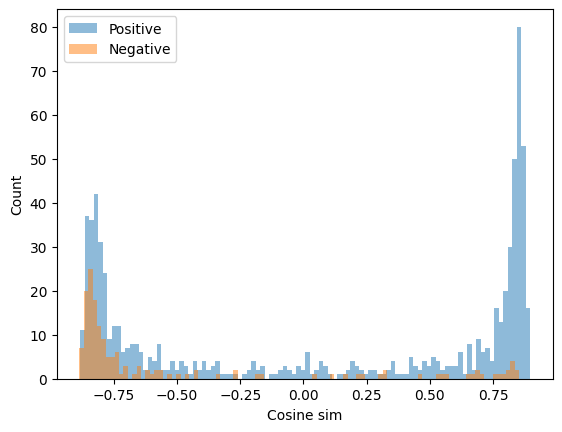

In [11]:
import matplotlib.pyplot as plt
import numpy as np

before_posi = []
before_nega = []

id_all = id_000 + id_001 + id_010 + id_011 + id_100 + id_101 + id_110 + id_111
id_tri_fail = id_001 + id_010 + id_101 + id_110
id_tri_suc = id_000 + id_011 + id_100 + id_111
for i in id_all :
    d = test_data_span[i]
    if d["task_type"] !="QA":
        continue
    mode = "triplet"
    if d["labels"] == 1:
        before_nega.append(d[mode])
    else:
        before_posi.append(d[mode])
        
plt.hist(before_posi, bins=100, alpha=0.5, label="Positive")
plt.hist(before_nega, bins=100, alpha=0.5, label="Negative")
plt.xlabel("Cosine sim")
plt.ylabel("Count")


plt.legend()
plt.show()




In [ ]:
# サンプリング

import json

for i in id_001 + id_101:
    d = test_data_span[i]
    if d["triplet"] > 0.90 and d["task_type"] == "Summary":
        print(json.dumps(d, indent=4, ensure_ascii=False,cls=NumpyEncoder))

In [8]:
id_all = id_000 + id_001 + id_010 + id_011 + id_100 + id_101 + id_110 + id_111
id_tri_fail = id_001 + id_010 + id_101 + id_110
id_tri_suc = id_000 + id_011 + id_100 + id_111

In [15]:
import json
for i in id_all:
    d = test_data_span[i]
    if d["task_type"] =="Summary" and d["source"]!="CNN/DM" and len(d["text"])<300:
        print(json.dumps(d, indent=4, ensure_ascii=False,cls=NumpyEncoder))  

{
    "ref": "'Bold and the Beautiful' Spoilers: Luna Leaks Eric's Secret To Ridge, RJ Betrayed By His New Love?\nThe Bold and the Beautiful (B&B) spoilers tease that Luna, the intern (Lisa Yamada), will reveal Eric Forrester's (John McCook) diagnosis to Ridge Forrester (Thorsten Kaye). She Knows Soaps reports that Luna wants to help RJ Forrester (Joshua Hoffman) and take the burden of this heavy secret from his shoulders.\nOn Friday's episode, B&B revealed that Luna is Li Flannigan's (Naomi Matsuda) niece. Her mother warned her to stay away from the Forresters. She appeared to want to protect her daughter from heartbreak. She could be a long-lost Forrester somehow. However, we have yet to learn how.\nNow, back to RJ. Lune worries that the pressure of keeping Eric's secret is too heavy for her new friend. She urges him to tell his father because Eric's health condition seems more severe than he initially said.\nThe Bold and the Beautiful spoilers say that RJ knows he should tell his da

In [16]:
sample3 = []
for i in id_all:
    if test_data_span[i]["task_type"]!="Summary":
        continue
    
    hal_type2 = []
    for hal_id in test_data_span[i]["hallucination_id"]:
        hal_type2.append(hal_id["label_type"])
    
    if "Subtle Conflict" in hal_type2:
        sample3.append(test_data_span[i])

In [17]:
sample3

[{'ref': 'Their relationship led to jail time for her, but Mary Kay Letourneau Fualaau wants the world to know that she and her husband, Vili Fualaau, are still happily together. She was a married 34-year-old teacher and mother of four in Seattle in 1996 when she began an affair with Fualaau, her 13-year-old student. Letourneau gave birth to her young lover\'s child and went on to serve more than seven years in prison on charges related to their sexual relationship. On Friday, ABC\'s "20/20" will air an exclusive interview with the couple, who will celebrate their 10th wedding anniversary on May 20. The pair wed soon after she was released from prison in 2005 and are now the parents of two teen girls. According to ABC, during the interview with Barbara Walters, "Mary Kay tells Walters what makes their marriage work in spite of their huge difference in their age." "She also discusses her surprising plans to teach again, as well as her intentions to have her status as a registered sex of